In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input # type: ignore
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.optimizers import Adam

In [76]:
# Load and preprocess the data
def load_data(image_folder, metadata_path, num_samples=None):
    # Load metadata
    metadata = pd.read_csv(metadata_path)
    
    # If num_samples is provided, take the first 'num_samples' rows
    if num_samples:
        metadata = metadata.head(num_samples)
    
    images = []
    missing_images = []
    
    for index, row in metadata.iterrows():
        image_file = os.path.join(image_folder, str(row['id'])+'.jpg')  # Adjust 'id' column if necessary
        image = cv2.imread(image_file)
        
        # Check if the image was loaded successfully
        if image is not None:
            image = cv2.resize(image, (128, 128))  # Resize to 128x128
            images.append(image)
        else:
            missing_images.append(image_file)
            print(f"Warning: Image {image_file} could not be loaded.")
    
    # Normalize pixel values to [0, 1]
    images = np.array(images) / 255.0  
    
    return images, metadata

In [78]:
# Load the data
image_folder = './COMP90086_2024_Project_train/train'  
metadata_path = './COMP90086_2024_Project_train/train.csv' 
images, metadata = load_data(image_folder, metadata_path, 5000)

metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                5000 non-null   int64
 1   shapeset          5000 non-null   int64
 2   type              5000 non-null   int64
 3   total_height      5000 non-null   int64
 4   instability_type  5000 non-null   int64
 5   cam_angle         5000 non-null   int64
 6   stable_height     5000 non-null   int64
dtypes: int64(7)
memory usage: 273.6 KB


In [50]:
def create_cnn_model(input_shape):
    cnn_input = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    cnn_output = Dense(128, activation='relu')(x)
    
    return Model(inputs=cnn_input, outputs=cnn_output)

# Define the neural network for metadata
def create_metadata_model(input_shape):
    metadata_input = Input(shape=input_shape)
    print(metadata_input)
    
    y = Dense(64, activation='relu')(metadata_input)
    y = Dropout(0.5)(y)
    y = Dense(32, activation='relu')(y)
    
    return Model(inputs=metadata_input, outputs=y)

# Combine CNN and metadata models
def create_combined_model(image_shape, metadata_shape):
    cnn_model = create_cnn_model(image_shape)
    metadata_model = create_metadata_model(metadata_shape)
    
    # Concatenate the outputs of the CNN and metadata model
    combined = Concatenate()([cnn_model.output, metadata_model.output])
    
    # Add some fully connected layers after the concatenation
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(64, activation='relu')(z)
    
    # Final output layer for predicting stable height
    output = Dense(1, activation='linear')(z)
    
    # Create the complete model
    model = Model(inputs=[cnn_model.input, metadata_model.input], outputs=output)
    
    return model

# Create the model
image_shape = (128, 128, 3)  
metadata_shape = (5,)  

model = create_combined_model(image_shape, metadata_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

<KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_179>


In [53]:
X_train_images = images  # Preprocessed image data
X_train_metadata = metadata[["shapeset","type","total_height","instability_type","cam_angle"]]  # Select relevant metadata columns

y_train = metadata['stable_height']  # Target variable (stable height)

metadata_input = layers.Input(shape=(5,)) 

In [54]:
model.fit([X_train_images, X_train_metadata], y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [79]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt

In [80]:
train_metadata, val_metadata = train_test_split(metadata, test_size=0.2, random_state=42, stratify=metadata['stable_height'])

image_size = (64, 64)
batch_size = 32

def load_and_preprocess_image(filepath):
    image = load_img(filepath, target_size=image_size)
    image = img_to_array(image) / 255.0  # Normalize pixel values
    return image

train_images = np.array([load_and_preprocess_image(os.path.join(image_folder, str(fname)+'.jpg')) for fname in train_metadata['id']])
train_labels = train_metadata['stable_height'].values 

# Load images for validation
val_images = np.array([load_and_preprocess_image(os.path.join(image_folder, str(fname)+'.jpg')) for fname in val_metadata['id']])
val_labels = val_metadata['stable_height'].values  

train_features = train_metadata[["shapeset","type","total_height","instability_type","cam_angle"]].values
val_features = val_metadata[["shapeset","type","total_height","instability_type","cam_angle"]].values

In [82]:
# Define CNN model for image input
image_input = Input(shape=(image_size[0], image_size[1], 3))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

In [83]:
# Define input for metadata
metadata_input = Input(shape=(train_features.shape[1],))
y = Dense(32, activation='relu')(metadata_input)

In [84]:
# Combine both inputs
combined = Concatenate()([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(1, activation='linear')(z)  # Output layer for regression

In [85]:
# Create the model
model = Model(inputs=[image_input, metadata_input], outputs=z)

# Compile the model
model.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

# Train the model
history = model.fit(
    [train_images, train_features],
    train_labels,
    validation_data=([val_images, val_features], val_labels),
    epochs=20,
    batch_size=batch_size
)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 2.9664 - mean_absolute_error: 1.3576 - val_loss: 1.4477 - val_mean_absolute_error: 0.9841
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 1.5215 - mean_absolute_error: 0.9765 - val_loss: 1.0500 - val_mean_absolute_error: 0.8315
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.4095 - mean_absolute_error: 0.9389 - val_loss: 1.0144 - val_mean_absolute_error: 0.8139
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.2730 - mean_absolute_error: 0.8841 - val_loss: 0.9215 - val_mean_absolute_error: 0.7563
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.1901 - mean_absolute_error: 0.8506 - val_loss: 0.9151 - val_mean_absolute_error: 0.7583
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.1711 - mean_absolute_error: 0.8512 - val_loss: 0.8793 - val_mean_absolute_error: 0.7176
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.9890 - mean_absolute_error: 0.7

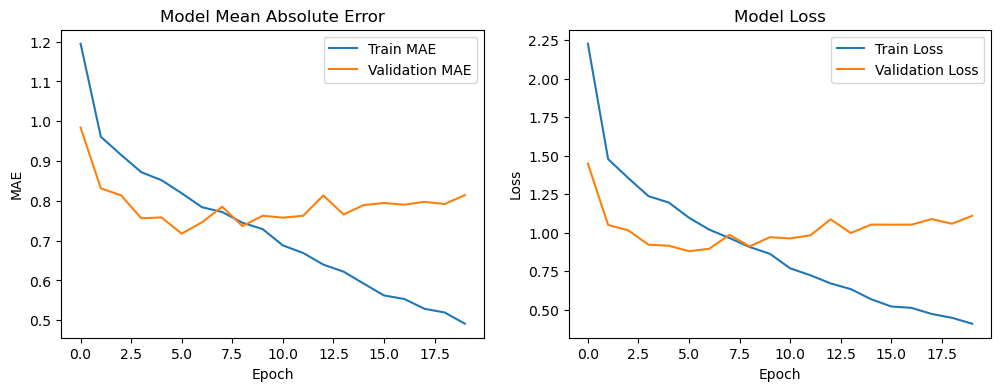

In [86]:
# Plot training & validation accuracy and loss (optional)
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

plot_history(history)

# Save the model
model.save('cnn_with_metadata_model.h5')

In [75]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore

# Define function to load and preprocess a single image
def load_and_preprocess_single_image(filepath):
    image = load_img(filepath, target_size=(64, 64))  # Ensure the size matches the training images
    image = img_to_array(image) / 255.0  # Normalize pixel values
    return image

# Path to the image you want to test
test_image_path = './COMP90086_2024_Project_test/test/33287.jpg'

# Load and preprocess the test image
test_image = load_and_preprocess_single_image(test_image_path)

# Prepare the corresponding metadata for the test image
# Ensure the metadata matches the feature columns used in training
test_metadata = np.array([[2,1,6,2,1]])  # Replace with actual feature values

# Expand dimensions to match the input shape (1, height, width, channels)
test_image = np.expand_dims(test_image, axis=0)

# Make a prediction
predicted_value = model.predict([test_image, test_metadata])

# Print the prediction result
print(f'Predicted Value: {predicted_value[0][0]}')  # Assuming a single numerical output


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Predicted Value: 3.1463022232055664
